In [1]:
!pip install shap

In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c1b3dd5dbe099df02a84a05edfb3b13bff5fe08352b98361a0651efc931000ea
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import shap

In [7]:
data = pd.read_csv("/content/PS_20174392719_1491204439457_log.csv")
df = data

In [8]:
print(df.head())
print(df.info())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 co

In [9]:
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])
df['isFraud'] = df['isFraud'].astype(int)

In [10]:
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type']
X = df[features]
y = df['isFraud']

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_train)

IsolationForest(contamination=0.01, random_state=42)

In [14]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:33:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [15]:
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

In [16]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.95      0.77      0.85      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.89      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524

AUC-ROC Score: 0.9996718466777957


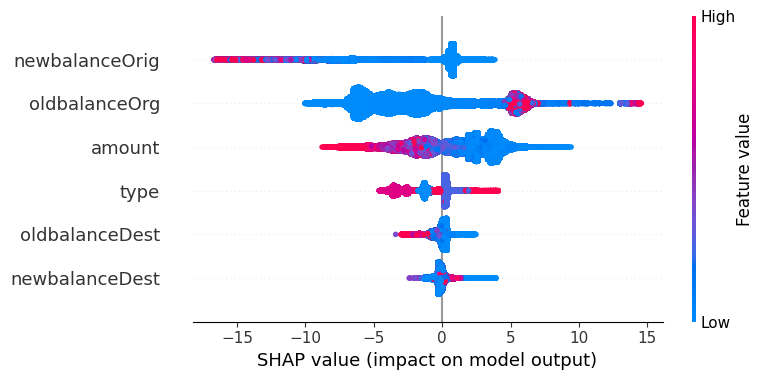

In [17]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features)